In [1]:
# importing the libraries
import pandas as pd
import numpy as np

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from pytorch_model_summary import summary
import time
import os
import copy
import shutil
import random
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
folder = ['1', '2', '3', '4', '5']
vid_dir = 'I://HandVideos//new hand videos'
dest_dir = "F://Handproject//#####"

In [ ]:
# for i in folder:
#     dir = "I://HandVideos//new hand videos//Dataimage//"+i 
#     os.makedirs(dir)

In [ ]:
# for i in folder:
#     dir = vid_dir+"//"+i 
#     lst = os.listdir(dir)
#     dst = "I://HandVideos//new hand videos//dataset//"+i
#     currentframe = 0
#     for j in lst:
#         cam = cv2.VideoCapture(dir+"//"+j)

#         while(True):
#             ret, frame = cam.read()
#             if ret:
#                 name = dst+"//"+str(currentframe)+".jpg"
#                 print("creating ..." + name)
#                 cv2.imwrite(name, frame)
#                 currentframe += 1
            
#             else:
#                 break
        
#         cam.release()
#         cv2.destroyAllWindows()

In [ ]:
# from PIL import Image
# import os, sys

# inputfolder = 'I://HandVideos//new hand videos//dataset//'
# outputfolder = 'I://HandVideos//new hand videos//optimaldataset//'

# if not os.path.exists(outputfolder):
#         os.makedirs(outputfolder)

# for i in range(1,6):
#     if not os.path.exists(outputfolder+str(i)):
#         os.makedirs(outputfolder+str(i))

# for i in range(1,6):
#     path = inputfolder+str(i)+'/'
#     print(path)
#     dirs = os.listdir(path)
#     print(len(dir))
#     imgnum = 0
#     for item in dirs:
#         if os.path.isfile(path+item):
#             im = Image.open(path+item)
#             f, e = os.path.splitext(path+item)
#             imResize = im.resize((224,224), Image.ANTIALIAS)
#             imResize.save(outputfolder + str(i)+'/'+ str(imgnum) + ' resized.jpg', 'JPEG', quality=90)
#             print('coping:'+outputfolder + str(i)+'/'+ str(imgnum) + ' resized.jpg')
#             imgnum += 1

In [ ]:
import os
import random
from shutil import copyfile

def img_train_test_split(img_source_dir, train_size):
    """
    Randomly splits images over a train and validation folder, while preserving the folder structure
    
    Parameters
    ----------
    img_source_dir : string
        Path to the folder with the images to be split. Can be absolute or relative path   
        
    train_size : float
        Proportion of the original images that need to be copied in the subdirectory in the train folder
    """    
    if not (isinstance(img_source_dir, str)):
        raise AttributeError('img_source_dir must be a string')
        
    if not os.path.exists(img_source_dir):
        raise OSError('img_source_dir does not exist')
        
    if not (isinstance(train_size, float)):
        raise AttributeError('train_size must be a float')
        
    # Set up empty folder structure if not exists
    if not os.path.exists('dataset'):
        os.makedirs('dataset')
    else:
        if not os.path.exists('dataset/train'):
            os.makedirs('dataset/train')
        if not os.path.exists('dataset/validation'):
            os.makedirs('dataset/validation')
            
    # Get the subdirectories in the main image folder
    subdirs = [subdir for subdir in os.listdir(img_source_dir) if os.path.isdir(os.path.join(img_source_dir, subdir))]

    for subdir in subdirs:
        subdir_fullpath = os.path.join(img_source_dir, subdir)
        if len(os.listdir(subdir_fullpath)) == 0:
            print(subdir_fullpath + ' is empty')
            break

        train_subdir = os.path.join('dataset/train', subdir)
        validation_subdir = os.path.join('dataset/validation', subdir)

        # Create subdirectories in train and validation folders
        if not os.path.exists(train_subdir):
            os.makedirs(train_subdir)

        if not os.path.exists(validation_subdir):
            os.makedirs(validation_subdir)

        train_counter = 0
        validation_counter = 0

        # Randomly assign an image to train or validation folder
        for filename in os.listdir(subdir_fullpath):
            if filename.endswith(".jpg") or filename.endswith(".png"): 
                fileparts = filename.split('.')

                if random.uniform(0, 1) <= train_size:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(train_subdir, str(train_counter) + '.' + fileparts[1]))
                    train_counter += 1
                else:
                    copyfile(os.path.join(subdir_fullpath, filename), os.path.join(validation_subdir, str(validation_counter) + '.' + fileparts[1]))
                    validation_counter += 1
                    
        print('Copied ' + str(train_counter) + ' images to dataset/train/' + subdir)
        print('Copied ' + str(validation_counter) + ' images to dataset/validation/' + subdir)

In [ ]:
# src = 'I://HandVideos//new hand videos//optimaldataset'
# img_train_test_split(src, 0.80)

In [3]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision

In [4]:

mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

imagedatatransforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize(mean_nums, std_nums),
    ]),
    'validation' : transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize(mean_nums, std_nums),
    ]),
}

#load dataset
imagedataset = {x: datasets.ImageFolder(os.path.join('F://Handproject//#####//dataset//', x), imagedatatransforms[x])
                for x in ['train', 'validation']}

#image data lodar
imagedataloader = {y: torch.utils.data.DataLoader(imagedataset[y], batch_size = 32, shuffle=True) 
                   for y in ['train', 'validation']}

# dataset size
dataset_size = {x: len(imagedataset[x]) for x in ['train', 'validation']}
class_names = imagedataset['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Visualize some images
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([mean_nums])
    std = np.array([std_nums])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  #

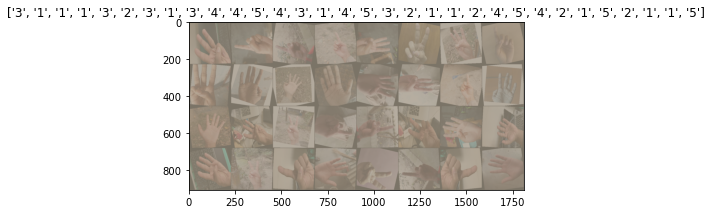

In [6]:
# Grab some of the training data to visualize
inputs, classes = next(iter(imagedataloader['train']))

# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

torch.Size([3, 224, 224])
Dataset Classes:  ['1', '2', '3', '4', '5']
Training Images:  486
Validation Images:  122


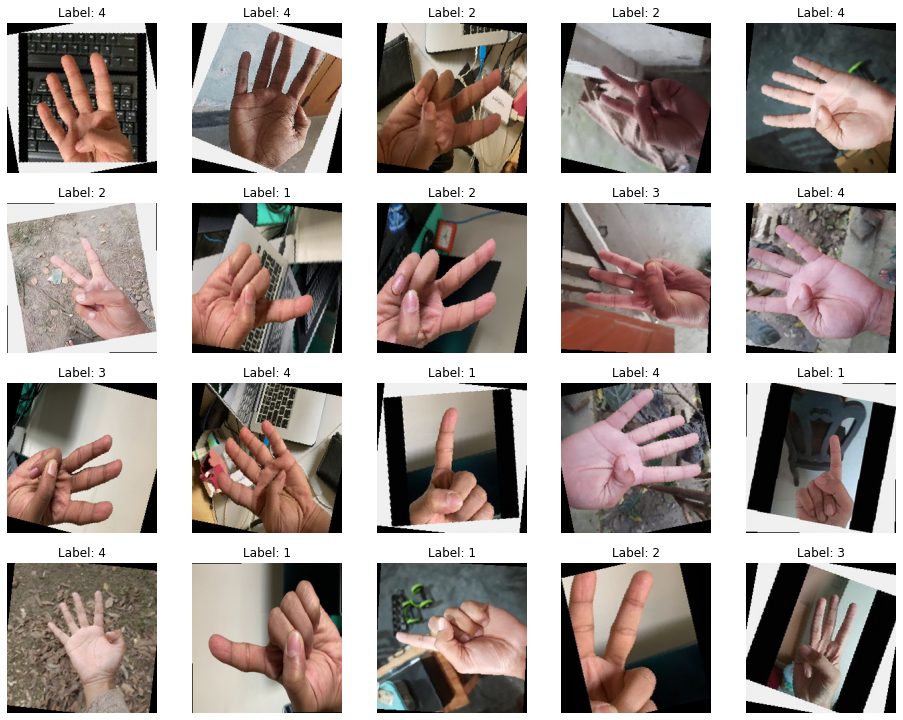

In [7]:
#show sample images
for batch_idx, (data, target) in enumerate(imagedataloader['train']): 
    print(data[0].shape)

    plt.figure(figsize=(16, 16))
    for i in range(20):
        img = data[i].permute(1, 2, 0)
        label = target[i].item()
        plt.subplot(5,5,i+1)
        plt.axis('off')
        plt.title("Label: {}".format(class_names[label]))
        plt.imshow(img)
    if batch_idx == 0: break
print("Dataset Classes: ", class_names)
print("Training Images: ", len(imagedataloader['train']))
print("Validation Images: ", len(imagedataloader['validation']))

In [8]:
import torch.nn.functional as Func

In [9]:
import torch.nn.functional as Func

class MYCNN(nn.Module):
    def __init__(self):
        super().__init__() 
        #convolution layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels =32, padding=1, kernel_size=3) 
        self.pool1 = nn.MaxPool2d(2) 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels =64, padding=1, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels =128, padding=1, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2) 
        #fully connected layer
        self.fc1 = nn.Linear(128*28*28, 512)
        #dropout to reduce overfitting
        self.drop = nn.Dropout(0.2) 
        #output 5 classes
        self.out = nn.Linear(512, 5)

    def forward(self, x):
        x=x
        x=self.conv1(x)
        x=Func.relu(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=Func.relu(x)
        x=self.pool2(x)
        x = self.drop(x)  
        x=self.conv3(x)
        x=Func.relu(x)
        x=self.pool3(x)
        
        x = x.view(-1, 128*28*28) 
        x = Func.relu(self.fc1(x))
        x = self.drop(x)
        x = self.out(x) 

        return Func.softmax(x, dim=1)

In [21]:
# defining the model
model = MYCNN()
model.to(device)
# # show input shape
print(summary(MYCNN(), torch.zeros((1, 3, 224, 224)), show_input=True))

-------------------------------------------------------------------------
      Layer (type)           Input Shape         Param #     Tr. Param #
          Conv2d-1      [1, 3, 224, 224]             896             896
       MaxPool2d-2     [1, 32, 224, 224]               0               0
          Conv2d-3     [1, 32, 112, 112]          18,496          18,496
       MaxPool2d-4     [1, 64, 112, 112]               0               0
         Dropout-5       [1, 64, 56, 56]               0               0
          Conv2d-6       [1, 64, 56, 56]          73,856          73,856
       MaxPool2d-7      [1, 128, 56, 56]               0               0
          Linear-8           [1, 100352]      51,380,736      51,380,736
         Dropout-9              [1, 512]               0               0
         Linear-10              [1, 512]           2,565           2,565
Total params: 51,476,549
Trainable params: 51,476,549
Non-trainable params: 0
---------------------------------------------

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()
    
    loss_history = dict()
    train_loss_history = []    
    val_loss_history = []    
    acc_history = dict()
    train_acc_history = []    
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        epoch_start_time = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'validation']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            #print('Iterating through data...')

            for inputs, labels in imagedataloader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
            
            #if phase == 'train':
                #scheduler.step()

            epoch_loss = current_loss / dataset_size[phase]
            epoch_acc = current_corrects.double() / dataset_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            
            if phase == 'validation':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
        epoch_time_elapsed = time.time() - epoch_start_time
        print('-'*5, '{:.0f}m {:.0f}s'.format(epoch_time_elapsed // 60, epoch_time_elapsed % 60))

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    loss_history['train'] = train_loss_history
    loss_history['validation'] = val_loss_history
    
    acc_history['train'] = train_acc_history
    acc_history['validation'] = val_acc_history
    
    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model, loss_history, acc_history

In [25]:
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# defining the loss function
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.2)
best_model, acc_history, loss_history = train_model(model, criterion, optimizer, lr_scheduler, num_epochs=30)
torch.save(best_model.state_dict(), 'handmodel_pytorch_second.pt')

Epoch 0/29
----------
train Loss: 1.4035 Acc: 0.4945
validation Loss: 1.2677 Acc: 0.6505
----- 1m 3s

Epoch 1/29
----------
train Loss: 1.2404 Acc: 0.6693
validation Loss: 1.1164 Acc: 0.8070
----- 1m 3s

Epoch 2/29
----------
train Loss: 1.0961 Acc: 0.8192
validation Loss: 1.0310 Acc: 0.8876
----- 1m 4s

Epoch 3/29
----------
train Loss: 1.0345 Acc: 0.8785
validation Loss: 0.9927 Acc: 0.9186
----- 1m 4s

Epoch 4/29
----------
train Loss: 1.0037 Acc: 0.9074
validation Loss: 0.9757 Acc: 0.9361
----- 1m 3s

Epoch 5/29
----------
train Loss: 0.9854 Acc: 0.9244
validation Loss: 0.9563 Acc: 0.9510
----- 1m 3s

Epoch 6/29
----------
train Loss: 0.9717 Acc: 0.9369
validation Loss: 0.9516 Acc: 0.9544
----- 1m 3s

Epoch 7/29
----------
train Loss: 0.9639 Acc: 0.9453
validation Loss: 0.9433 Acc: 0.9637
----- 1m 3s

Epoch 8/29
----------
train Loss: 0.9577 Acc: 0.9504
validation Loss: 0.9412 Acc: 0.9660
----- 1m 3s

Epoch 9/29
----------
train Loss: 0.9442 Acc: 0.9629
validation Loss: 0.9332 Acc: 

In [26]:
train_loss_hist = []
train_loss_hist = []
val_loss_hist = []
train_acc_hist = []
val_acc_hist = []

train_loss_hist = [h for h in loss_history['train']]
val_loss_hist = [h for h in loss_history['validation']]
train_acc_hist = [h for h in acc_history['train']]
val_acc_hist = [h for h in acc_history['validation']]

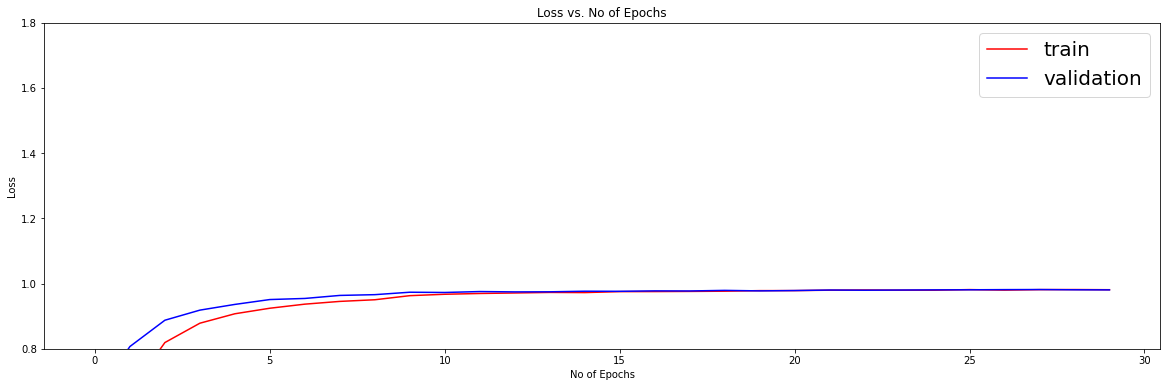

In [27]:
plt.figure(figsize=(20,6))
plt.title("Loss vs. No of Epochs")
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.plot(range(30), train_loss_hist,'r-', label="train")
plt.plot(range(30), val_loss_hist,'b-', label="validation")
plt.ylim((0.8,1.8))
plt.legend(prop={'size': 20}, loc='upper right')

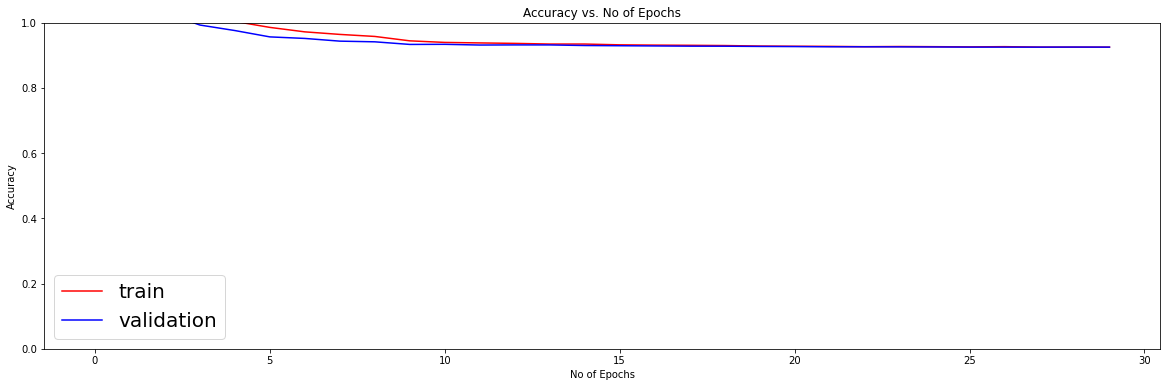

In [28]:
plt.figure(figsize=(20,6))
plt.title("Accuracy vs. No of Epochs")
plt.xlabel("No of Epochs")
plt.ylabel("Accuracy")
plt.plot(range(30), train_acc_hist,'r-', label="train")
plt.plot(range(30), val_acc_hist,'b-', label="validation")
plt.ylim((0,1.))
plt.legend(prop={'size': 20}, loc='lower left')
plt.show()